# Load Core-based statistical areas (CBSA) data from the US Census Bureau

IMPORTANT: public use microdata areas have duplicates, and are not unique. They can be made unique using the combination of the state and the PUMA code.

In [2]:
# Load duckdb, which lets us efficiently load large files
import duckdb

# Load pandas, which lets us manipulate dataframes
import pandas as pd

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# Set configrations on jupysql to directly output data to Pandas and to simplify the output that is printed to the notebook.
%config SqlMagic.autopandas = True

%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Allow named parameters (python variables) in SQL cells
%config SqlMagic.named_parameters=True

# Connect jupysql to DuckDB using a SQLAlchemy-style connection string. Either connect to an in memory DuckDB, or a file backed db.
%sql duckdb:///:memory:

/Users/me/jaanli/exploring_american_community_survey_data/.venv/lib/python3.11/site-packages/sql/traits.py:20: FutureWarning: named_parameters: boolean values are now deprecated. Value True will be treated as "enabled". 
Please use a valid option: "warn", "enabled", or "disabled". 
For more information, see the docs: https://jupysql.ploomber.io/en/latest/api/configuration.html#named-parameters
  warnings.warn(


In [10]:
!wget https://www2.census.gov/geo/tiger/TIGER2020/CBSA/tl_2020_us_cbsa.zip -O ~/data/american_community_survey/shapefiles/tl_2020_us_cbsa.zip
!unzip -o ~/data/american_community_survey/shapefiles/tl_2020_us_cbsa.zip -d ~/data/american_community_survey/shapefiles/

--2024-03-03 16:42:27--  https://www2.census.gov/geo/tiger/TIGER2020/CBSA/tl_2020_us_cbsa.zip
Resolving www2.census.gov (www2.census.gov)... 23.73.234.140
Connecting to www2.census.gov (www2.census.gov)|23.73.234.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/Users/me/data/american_community_survey/shapefiles/tl_2020_us_cbsa.zip’

/Users/me/data/amer     [      <=>           ]  31.60M  27.5MB/s    in 1.1s    

2024-03-03 16:42:28 (27.5 MB/s) - ‘/Users/me/data/american_community_survey/shapefiles/tl_2020_us_cbsa.zip’ saved [33140121]

Archive:  /Users/me/data/american_community_survey/shapefiles/tl_2020_us_cbsa.zip
 extracting: /Users/me/data/american_community_survey/shapefiles/tl_2020_us_cbsa.cpg  
  inflating: /Users/me/data/american_community_survey/shapefiles/tl_2020_us_cbsa.dbf  
  inflating: /Users/me/data/american_community_survey/shapefiles/tl_2020_us_cbsa.prj  
  inflating: /Users/me/data/american_commun

In [3]:
import geopandas as gpd

In [4]:
gdf_cbsa_2020 = gpd.read_file('zip:///Users/me/data/american_community_survey/shapefiles/tl_2020_us_cbsa.zip')

<Axes: >

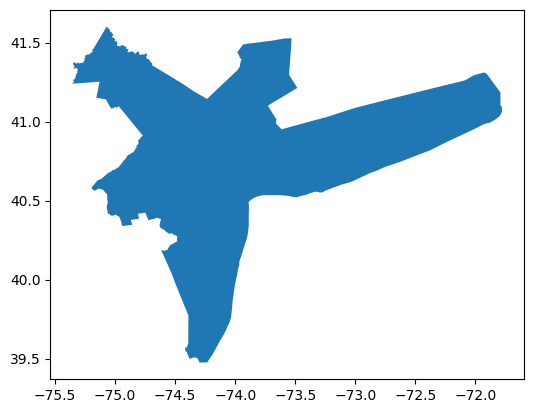

In [5]:
gdf_cbsa_2020[gdf_cbsa_2020['NAME'].str.contains('New York')].plot()

In [17]:
gdf_puma_2020 = gpd.read_file('~/data/american_community_survey/shapefiles/ipums_puma_2020/ipums_puma_2020.shp')

In [23]:
%%sql 
LOAD spatial;

,Success


In [26]:
%%sql 
COPY(
WITH acs_microdata AS (
  SELECT * FROM '~/data/american_community_survey/2020_census_microdata_tiger_shapefile.shp'
),
us_cbsa AS (
  SELECT * FROM '~/data/american_community_survey/shapefiles/tl_2020_us_cbsa.shp'
),
new_york_cbsa AS (
  SELECT * FROM us_cbsa
  WHERE NAMELSAD LIKE '%New York%'
),
intersecting_rows AS (
  SELECT acs.*
  FROM acs_microdata acs
  JOIN new_york_cbsa nyc
  ON ST_Intersects(acs.geom, nyc.geom)
)
SELECT * FROM intersecting_rows
) TO '~/data/american_community_survey/shapefiles/newyork_newark_cbsa_pumas/newyork_newark_cbsa_pumas.shp' WITH (FORMAT GDAL, DRIVER 'ESRI Shapefile');

,Success


In [27]:
%%sql 
SELECT * FROM '~/data/american_community_survey/shapefiles/newyork_newark_cbsa_pumas/newyork_newark_cbsa_pumas.shp'

,STATEFP20,PUMACE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geom
0,36,02804,3602804,Dutchess County (Southwest)--Fishkill & Wappin...,G6120,S,240325417,24525886,+41.5941970,-073.9134134,"[2, 4, 63, 0, 0, 0, 0, 0, 16, 0, 148, 194, 112..."
1,36,02701,3602701,Sullivan & Ulster (West) Counties PUMA,G6120,S,4195598841,103398369,+41.8093993,-074.6217631,"[2, 4, 184, 0, 0, 0, 0, 0, 28, 74, 150, 194, 1..."
2,36,02901,3602901,Orange County (Northeast)--Greater Newburgh Ci...,G6120,S,420131440,26776009,+41.5074504,-074.0987065,"[2, 4, 125, 0, 0, 0, 0, 0, 176, 155, 148, 194,..."
3,36,02805,3602805,Putnam County & Southern Dutchess County PUMA,G6120,S,856544186,46595094,+41.4576193,-073.7246077,"[2, 4, 69, 0, 0, 0, 0, 0, 15, 247, 147, 194, 1..."
4,09,20904,0920904,Western North PUMA,G6120,S,664457917,35252911,+41.4839832,-073.4066188,"[2, 4, 64, 0, 0, 0, 0, 0, 86, 22, 147, 194, 25..."
...,...,...,...,...,...,...,...,...,...,...,...
164,34,01204,3401204,Ocean County (Northwest) PUMA,G6120,S,571412693,7646932,+40.0414307,-074.3841920,"[2, 4, 230, 0, 0, 0, 0, 0, 49, 27, 149, 194, 1..."
165,34,01202,3401202,Ocean County (Central)--Toms River & Berkeley ...,G6120,S,234280400,80165247,+39.9399652,-074.1680549,"[2, 4, 105, 0, 0, 0, 0, 0, 199, 168, 148, 194,..."
166,34,02003,3402003,Burlington County (South & East) PUMA,G6120,S,1611409133,32099527,+39.8457997,-074.6047072,"[2, 4, 97, 0, 0, 0, 0, 0, 175, 190, 149, 194, ..."
167,34,01201,3401201,Ocean County (South) PUMA,G6120,S,672829856,624978348,+39.7348923,-074.2234753,"[2, 4, 213, 0, 0, 0, 0, 0, 83, 222, 148, 194, ..."


In [4]:
gdf_newyork_newark_cbsa_pumas = gpd.read_file('/Users/me/data/american_community_survey/shapefiles/newyork_newark_cbsa_pumas/newyork_newark_cbsa_pumas.shp')

<Axes: >

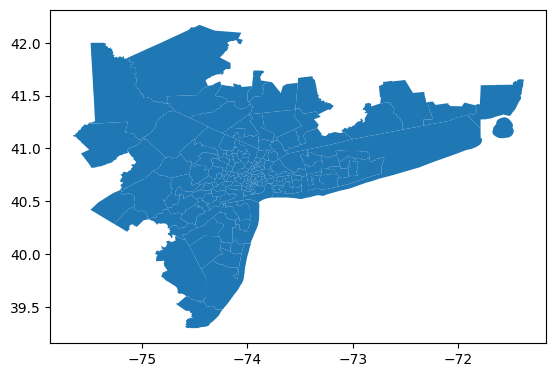

In [7]:
gdf_newyork_newark_cbsa_pumas.plot()

In [7]:
name_state_puma = gdf_newyork_newark_cbsa_pumas[['NAMELSAD20', 'STATEFP20', 'PUMACE20']]
name_state_puma.rename(columns={'NAMELSAD20': 'name', 'STATEFP20': 'state_code', 'PUMACE20': 'puma'}, inplace=True)
name_state_puma.to_parquet('/Users/me/data/american_community_survey/shapefiles/newyork_newark_cbsa_2020_pumas_intersection_with_2020_cbsa.parquet')


/var/folders/j6/7vrpplt53hs3z_nyd8j0zqsh0000gn/T/ipykernel_96273/606294559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_state_puma.rename(columns={'NAMELSAD20': 'name', 'STATEFP20': 'state_code', 'PUMACE20': 'puma'}, inplace=True)


In [8]:
df = pd.read_parquet('/Users/me/data/american_community_survey/shapefiles/newyork_newark_cbsa_2020_pumas_intersection_with_2020_cbsa.parquet')

In [9]:
df

,name,state_code,puma
0,Dutchess County (Southwest)--Fishkill & Wappin...,36,02804
1,Sullivan & Ulster (West) Counties PUMA,36,02701
2,Orange County (Northeast)--Greater Newburgh Ci...,36,02901
3,Putnam County & Southern Dutchess County PUMA,36,02805
4,Western North PUMA,09,20904
...,...,...,...
164,Ocean County (Northwest) PUMA,34,01204
165,Ocean County (Central)--Toms River & Berkeley ...,34,01202
166,Burlington County (South & East) PUMA,34,02003
167,Ocean County (South) PUMA,34,01201


In [47]:
nyc_cbsa_pumas = gdf_newyork_newark_cbsa_pumas[['NAMELSAD20', 'STATEFP20', 'PUMACE20']].set_index('NAMELSAD20').to_dict(orient='index')

In [48]:
nyc_cbsa_pumas

{'Dutchess County (Southwest)--Fishkill & Wappinger town PUMA': {'STATEFP20': '36',
  'PUMACE20': '02804'},
 'Sullivan & Ulster (West) Counties PUMA': {'STATEFP20': '36',
  'PUMACE20': '02701'},
 'Orange County (Northeast)--Greater Newburgh City PUMA': {'STATEFP20': '36',
  'PUMACE20': '02901'},
 'Putnam County & Southern Dutchess County PUMA': {'STATEFP20': '36',
  'PUMACE20': '02805'},
 'Western North PUMA': {'STATEFP20': '09', 'PUMACE20': '20904'},
 'Orange County (Northwest) PUMA': {'STATEFP20': '36', 'PUMACE20': '02902'},
 'Shoreline Southeastern PUMA': {'STATEFP20': '09', 'PUMACE20': '20401'},
 'Lower Connecticut River Valley PUMA': {'STATEFP20': '09',
  'PUMACE20': '20500'},
 'Orange County (Southeast) PUMA': {'STATEFP20': '36', 'PUMACE20': '02903'},
 'Rockland County (North)--New City & Congers PUMA': {'STATEFP20': '36',
  'PUMACE20': '03001'},
 'Rockland County (West)--Spring Valley, Suffern Villages & Monsey PUMA': {'STATEFP20': '36',
  'PUMACE20': '03003'},
 'South Rhode Isl

In [52]:
import json
out_json_path = '/Users/me/data/american_community_survey/shapefiles/newyork_newark_cbsa_pumas/newyork_newark_cbsa_pumas.json'
with open(out_json_path, 'w') as f:
    f.write(json.dumps(nyc_cbsa_pumas))

In [17]:
gdf_newyork_newark_cbsa_pumas['PUMACE20'].isin(nyc_cbsa_pumas).sum()

169

In [22]:
gdf_newyork_newark_cbsa_pumas[gdf_newyork_newark_cbsa_pumas['PUMACE20'] == '04401']

,STATEFP20,PUMACE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
66,36,04401,3604401,NYC-Queens Community District 1--Astoria & Que...,G6120,S,17307796,3578404,+40.7706960,-073.9053441,"POLYGON ((-73.92021 40.74980, -73.92062 40.749..."


In [37]:
nyc_website_pumas = [
    "4103",
    "4104",
    "4107",
    "4108",
    "4109",
    "4110",
    "4111",
    "4112",
    "4121",
    "4165",
    "4204",
    "4205",
    "4207",
    "4208",
    "4209",
    "4210",
    "4211",
    "4212",
    "4221",
    "4263",
    "4301",
    "4302",
    "4303",
    "4304",
    "4305",
    "4306",
    "4307",
    "4308",
    "4309",
    "4310",
    "4311",
    "4312",
    "4313",
    "4314",
    "4315",
    "4316",
    "4317",
    "4318",
    "4401",
    "4402",
    "4403",
    "4404",
    "4405",
    "4406",
    "4407",
    "4408",
    "4409",
    "4410",
    "4411",
    "4412",
    "4413",
    "4414",
    "4501",
    "4502",
    "4503",
]

In [38]:
cbsa_pumas = gdf_newyork_newark_cbsa_pumas['PUMACE20'].values.tolist()

In [42]:
len([puma for puma in nyc_website_pumas if '0' + puma in cbsa_pumas]), len(nyc_website_pumas), len(cbsa_pumas)

(55, 55, 169)

In [44]:
print(cbsa_pumas)

['02804', '02701', '02901', '02805', '20904', '02902', '20401', '20500', '02903', '03001', '03003', '00400', '20604', '00500', '03102', '03103', '20902', '03002', '20901', '00306', '03111', '20903', '00308', '00504', '03112', '01600', '03110', '00503', '00307', '03113', '03114', '03304', '04208', '04212', '00304', '00305', '04207', '00502', '04205', '04211', '00301', '01501', '04112', '03301', '04263', '00501', '00600', '04204', '03308', '03303', '04109', '04210', '04209', '00303', '04110', '01503', '01403', '04221', '04111', '03202', '01401', '04107', '00302', '03201', '03302', '00604', '04401', '04108', '04403', '01405', '03310', '04104', '04407', '03203', '00603', '03307', '03204', '04411', '04402', '04165', '01502', '03309', '04404', '01404', '00601', '01402', '04406', '04103', '04408', '04301', '03207', '01407', '03205', '04405', '04302', '04121', '04409', '04304', '04303', '01406', '04412', '04308', '00602', '01901', '04309', '04316', '03313', '01504', '04306', '03211', '04410', 

## look at individual new york areas

In [27]:
gdf_newyork_newark_cbsa_pumas[gdf_newyork_newark_cbsa_pumas['PUMACE20'].isin(nyc_cbsa_pumas)]

,STATEFP20,PUMACE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,36,02804,3602804,Dutchess County (Southwest)--Fishkill & Wappin...,G6120,S,240325417,24525886,+41.5941970,-073.9134134,"POLYGON ((-73.91876 41.48978, -73.93377 41.488..."
1,36,02701,3602701,Sullivan & Ulster (West) Counties PUMA,G6120,S,4195598841,103398369,+41.8093993,-074.6217631,"POLYGON ((-74.66545 41.49685, -74.66552 41.496..."
2,36,02901,3602901,Orange County (Northeast)--Greater Newburgh Ci...,G6120,S,420131440,26776009,+41.5074504,-074.0987065,"POLYGON ((-74.07443 41.60365, -74.07440 41.603..."
3,36,02805,3602805,Putnam County & Southern Dutchess County PUMA,G6120,S,856544186,46595094,+41.4576193,-073.7246077,"POLYGON ((-73.71978 41.34886, -73.72519 41.348..."
4,09,20904,0920904,Western North PUMA,G6120,S,664457917,35252911,+41.4839832,-073.4066188,"POLYGON ((-73.18712 41.38912, -73.18735 41.389..."
...,...,...,...,...,...,...,...,...,...,...,...
164,34,01204,3401204,Ocean County (Northwest) PUMA,G6120,S,571412693,7646932,+40.0414307,-074.3841920,"POLYGON ((-74.26646 39.99098, -74.26670 39.990..."
165,34,01202,3401202,Ocean County (Central)--Toms River & Berkeley ...,G6120,S,234280400,80165247,+39.9399652,-074.1680549,"POLYGON ((-74.14479 40.01855, -74.14471 40.018..."
166,34,02003,3402003,Burlington County (South & East) PUMA,G6120,S,1611409133,32099527,+39.8457997,-074.6047072,"POLYGON ((-74.65558 40.16019, -74.65540 40.160..."
167,34,01201,3401201,Ocean County (South) PUMA,G6120,S,672829856,624978348,+39.7348923,-074.2234753,"POLYGON ((-73.99958 39.97680, -74.00760 39.936..."
